In [ ]:
%pip install scikit-learn
%pip install datasets
%pip install transformers
%pip install transformers[torch]
%pip install evaluate
%pip install pandas==2.0.3
%pip install torch
%pip install joblib
%pip install tqdm
%pip install progressbar

In [ ]:
# this cell is required for running in google collab VM
import os
if os.getenv("COLAB_RELEASE_TAG"):
    print("Running in Colab")
    import sys
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/')
    %cd /content/drive/MyDrive/Faks/research_uiktp
else:
   print("NOT in Colab")

In [3]:
import joblib
import torch
import sklearn
import evaluate
import numpy as np
import pandas as pd
from train_model import softmax, validate, predict_durations_for_tokenized_tensor_inputs as run_prediction
from get_task_durations import plot_durations_histogram
from data_utils import rename_columns, get_global_constants, balance_dataframe
from datasets import DatasetDict, Dataset
from make_dataset import split_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, TrainingArguments, Trainer

GPU is not available. CPU will be used to train the model
GPU is not available. CPU will be used to train the model


In [4]:
GLOBAL_CONSTANTS = get_global_constants()
print(GLOBAL_CONSTANTS)

GPU is not available. CPU will be used to train the model


                                                    text  label
0      This really should get fixed in the JBoss.org ...      4
1      We can still mention it, but since it's not ne...      5
2      When using MassIndexer and FSDirectory all is ...      4
3      Hibernate throws a NPE while deleting objects ...      5
4      It seems that if the field is not known by the...      3
...                                                  ...    ...
16556  There are 3rd party projects that would like t...      2
16557  The wiki pages * https://community.jboss.org/w...      4
16558  The html5 based archetypes in /jboss-as/archet...      5
16559  The jboss-as quickstart BOM is now in maven ce...      4
16560  See https://community.jboss.org/message/647192...      4

[16561 rows x 2 columns]
[4, 5, 3, 2]
GPU is not available. CPU will be used to train the model
GPU is not available. CPU will be used to train the model
GPU is not available. CPU will be used to train the model
GPU is not availabl

array([[<Axes: title={'center': 'label'}>]], dtype=object)

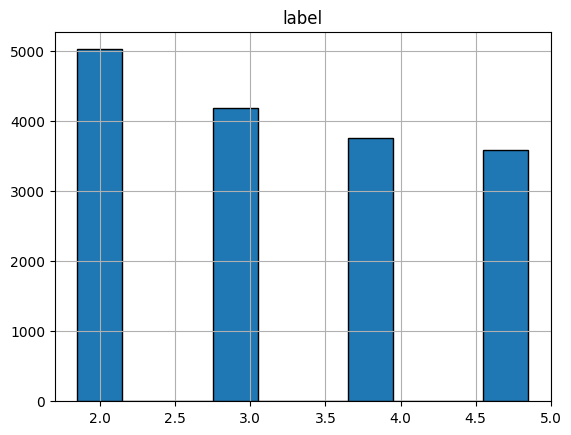

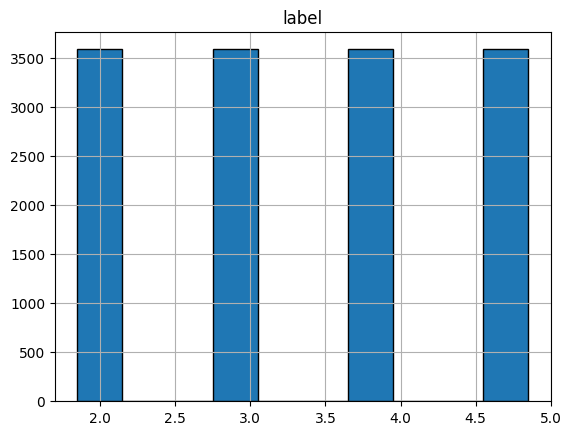

In [5]:
dataframe = pd.read_csv(GLOBAL_CONSTANTS.CSV_DATASET_PATH)
dataframe = rename_columns(dataframe)

print(dataframe)
plot_durations_histogram(dataframe, column_name='label')

dataframe = balance_dataframe(dataframe)
dataframe = dataframe.sample(frac=1, random_state=GLOBAL_CONSTANTS.RANDOM_STATE).reset_index(drop=True)

print(dataframe)
plot_durations_histogram(dataframe, column_name='label')

In [6]:
train_set, test_set, validation_set = split_dataset(dataframe, train_set_length=.8, test_set_length=.1, validation_set_length=.1, axis=0)
print(train_set)
print(test_set)
print(validation_set)

                                                    text  label
0      This is a somewhat long term item.Because of s...      5
1      The scripts and utilities in J2G should suppor...      3
2      Implement paging as per the proposal at <http:...      5
3      Currently Hive uses a default decimal type inf...      5
4      Platform JIRA for project JIRA:  http://jira.j...      3
...                                                  ...    ...
11486  When using MassIndexer and FSDirectory all is ...      4
11487  {code}def y = [null]def o = new Object() {  de...      5
11488  Steps to reproduce---------------------------1...      5
11489  The community portlet does not display properl...      3
11490  I have seen problems where the workspace is ou...      3

[11491 rows x 2 columns]
                                                    text  label
11491  When running derbyall, DerbyNetClient/lang/upd...      3
11492  The serialization logic for Arrays, elements a...      4
11493  Page pa

In [7]:
dataset = DatasetDict(
    {
        "train":Dataset.from_dict(train_set.to_dict('list')),
        "test":Dataset.from_dict(test_set.to_dict('list')),
        "validation":Dataset.from_dict(validation_set.to_dict('list'))
    }
)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11491
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1437
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1436
    })
})


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(jira_tasks, column_name="text"):
    ret = tokenizer(jira_tasks[column_name], padding="max_length", truncation=True)
    return ret

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_set = tokenized_datasets["train"]
test_set = tokenized_datasets["test"]
validation_set = tokenized_datasets["validation"]
print(train_set)
print(test_set)
print(validation_set)

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=11)

model.to(GLOBAL_CONSTANTS.DEVICE)

training_args = TrainingArguments(
    output_dir="training_logs",
    evaluation_strategy="epoch",
    num_train_epochs=4,
    learning_rate=2.5e-5,
    save_steps=3250,
    save_total_limit=1
    )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)
trainer.train()
print("Training finished")

In [ ]:
torch.save(model.state_dict(), GLOBAL_CONSTANTS.MODEL_PATH)
print("Model serialized")

In [ ]:
loaded_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=11)
loaded_model.load_state_dict(torch.load(GLOBAL_CONSTANTS.MODEL_PATH, map_location=GLOBAL_CONSTANTS.DEVICE_STRING))
print("Model loaded")

In [ ]:
loaded_model.eval()

VALIDATION_SAMPLE_SIZE = 16
input_text = validation_set['text']
input_ids = validation_set['input_ids']
input_masks = validation_set['attention_mask']
true_durations = validation_set['label']

input_ids = torch.tensor(input_ids)
input_masks = torch.tensor(input_masks)

predicted_durations = run_prediction(loaded_model, input_ids, input_masks)
print("Predicted duration: {}".format(predicted_durations))
print("Expected durations: {}".format(true_durations))

In [ ]:
from matplotlib import pyplot

distribution = [predicted_durations[i] - true_durations[i] for i in range(len(predicted_durations))]

pyplot.hist(distribution, bins=7)

In [ ]:
metrics = validate(true_durations, predicted_durations)
print(metrics)

In [ ]:
[print("{}: {}".format(distribution[i], input_text[i])) for i in range(len(distribution)) if distribution[i] > metrics['mean_absolute_error'] or distribution[i] < -metrics['mean_absolute_error']]